# MNIST experiments

In [ ]:
# | hide
import math
import torch
import torchvision.transforms as T
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from fastai.vision.all import *

### Hyper-parameters

In [ ]:
set_seed(0)
n_cores = num_cpus()


bs = 256                # batch size
w = 16                  # w=16/32/64/128  model width, number of hidden neurons
l = 1                   # l=1/2/4  leaf size of the tree in FFF model
d = int(math.log2(w/l)) # depth of the tree

First load the MNIST dataset

In [ ]:
from torchvision.datasets import MNIST

mean, std = 0.130652368068695068, 0.307504087686538696

train_dataset = MNIST('../data', train=True, download=True,
                             transform=T.Compose([
                                 T.ToTensor(),
                                 T.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data', train=False, download=True,
                            transform=T.Compose([
                                T.ToTensor(),
                                T.Normalize((mean,), (std,))
                            ]))

In [ ]:
num_cpus()
dls = DataLoaders(TfmdDL(train_dataset, bs, True, n_cores),TfmdDL(test_dataset, bs, False, n_cores))

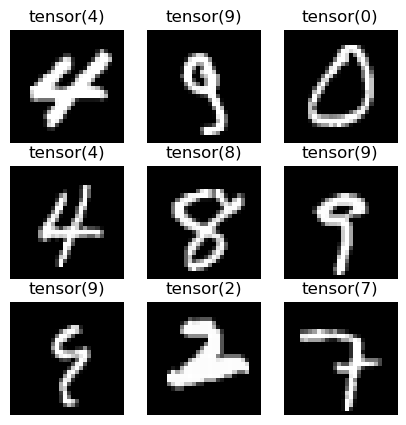

In [ ]:
show_image_batch(dls.one_batch(), cmap='gray', figsize=(5,5))

In [ ]:
dls.one_batch()[0].shape

torch.Size([256, 1, 28, 28])

# Baseline
Baseline model with single hidden layer of width `w`

In [ ]:
model_ff = nn.Sequential(
    nn.Linear(28*28, w),
    nn.PReLU(),
    nn.Linear(w, 2), # learn 2d projection
    nn.PReLU(),
    nn.Linear(2, 10)
)

Add callback that flattens 28x28 images into vectors of size 784 

In [ ]:
@before_batch_cb
def flatten(self, xb, yb): 
    return (xb[0].view(-1,28*28),),yb

In [ ]:
cbs = [flatten, ShowGraphCallback()]
learn = Learner(dls, model_ff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,1.454401,1.169935,0.576800,00:11
1,0.771795,0.729263,0.798500,00:12
2,0.606074,0.591851,0.849400,00:12
3,0.539118,0.517292,0.872900,00:10
4,0.496739,0.509435,0.875700,00:10
5,0.467292,0.481698,0.883000,00:10
6,0.439054,0.466460,0.890800,00:10
7,0.411830,0.455892,0.893900,00:11
8,0.409214,0.452209,0.895000,00:11
9,0.385308,0.450498,0.896800,00:12


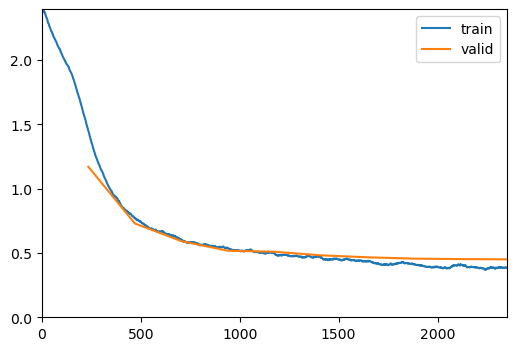

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [ ]:
# TODO get activations each epoch during training
class Activations2D(HookCallback):
    def __init__(self, module = None, **kwargs):
        super().__init__([module], **kwargs)
        
    def before_fit(self):
        super().before_fit()
        self.activations, self.targets = [], []
    
    def hook(self, m, i, o): return o
    
    def after_batch(self):
        '''Store activations and targets for batch'''
        self.activations.append(self.hooks.stored[0])
        self.targets.append(self.yb[0])
        super().after_batch()
        
    def after_fit(self):
        self.activations, self.targets = torch.cat(self.activations), torch.cat(self.targets)
        super().after_fit()
    
    def show_acts(self, figsize=(10,5), ax=None):
        if ax is None: _, ax = plt.subplots(figsize=figsize)
        sc = ax.scatter(self.activations[:,0], self.activations[:,1], alpha=0.6,
                   c=self.targets.tolist(), label=self.targets.tolist(), s=5)
        ax.set_title('2D activations')
        ax.legend(*sc.legend_elements())

In [ ]:
act = Activations2D(model_ff[-3])
learn.get_preds(dl = dls.valid, cbs=act);

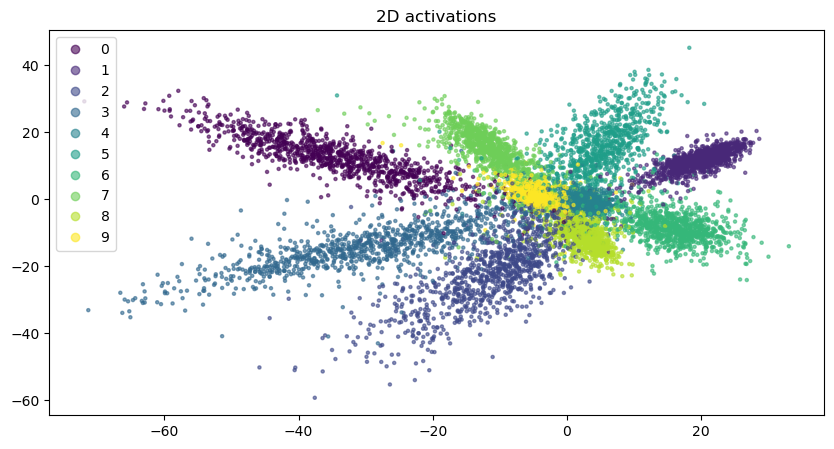

In [ ]:
act.show_acts(figsize=(10,5))

# Convolutional network

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.PReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
model_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    nn.Flatten(),
    nn.Linear(64, 2),      # 2d projection
    nn.PReLU(),
    nn.Linear(2, 10)
)

In [ ]:
cbs = [ShowGraphCallback()]
learn = Learner(dls, model_cnn, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,1.316086,1.018424,0.651000,00:14
1,0.493310,0.456879,0.894600,00:12
2,0.330460,0.297628,0.929400,00:14
3,0.276645,0.242243,0.944400,00:11
4,0.228975,0.193575,0.955100,00:12
5,0.193767,0.188732,0.957600,00:11
6,0.155996,0.167901,0.963100,00:12
7,0.136099,0.162628,0.965100,00:12
8,0.110416,0.155696,0.967500,00:11
9,0.098746,0.154569,0.966900,00:15


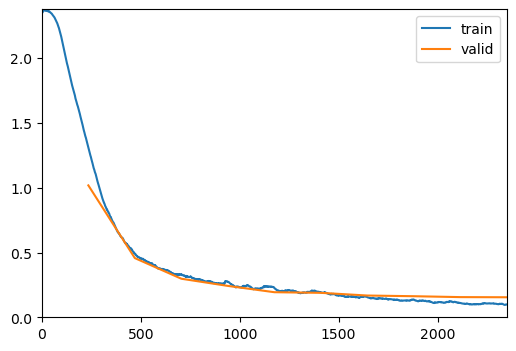

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [ ]:
act = Activations2D(model_cnn[-3])
learn.get_preds(dl = dls.valid, cbs=act);

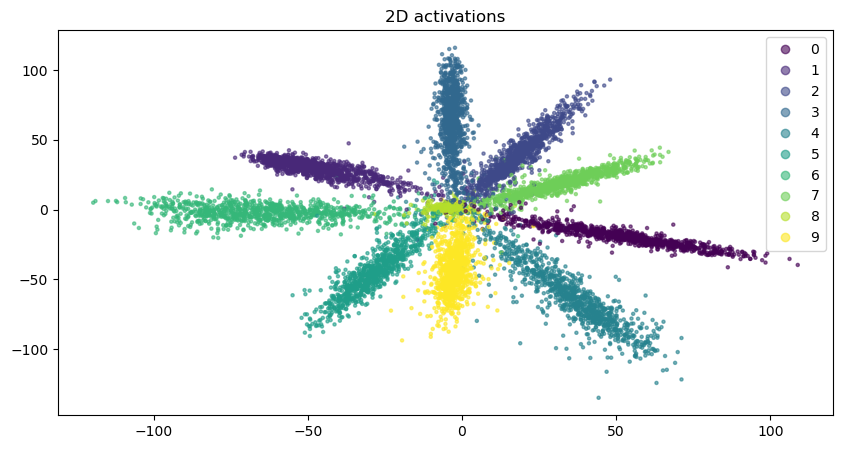

In [ ]:
act.show_acts(figsize=(10,5))

## Fast Feed-forward network

Comparison of Feed-forward layer, Mixture-of-experts layer and Fast Feed-forward layer.

FFF forms a tree that splits space into regions

<img width="900" src="../images/ff_moe_fff.png" id="jupyter"/>

In [ ]:
from typing import Optional
import torch

from torch import nn
import math


def compute_entropy_safe(p: torch.Tensor, minus_p: torch.Tensor) -> torch.Tensor:
    EPSILON = 1e-6
    p = torch.clamp(p, min=EPSILON, max=1-EPSILON)
    minus_p = torch.clamp(minus_p, min=EPSILON, max=1-EPSILON)
    return -p * torch.log(p) - minus_p * torch.log(minus_p)


class FFF(nn.Module):
    """
    An implementation of fast feedforward networks from the paper "Fast Feedforward Networks".
    """

    def __init__(self,
                 input_width: int, leaf_width: int, output_width: int, depth: int,
                 activation=nn.ReLU(), dropout: float = 0.0, train_hardened: bool = False,
                 region_leak: float = 0.0, usage_mode: str = 'none'):
        super().__init__()
        self.input_width = input_width
        self.leaf_width = leaf_width
        self.output_width = output_width
        self.dropout = dropout
        self.activation = activation
        self.train_hardened = train_hardened
        self.region_leak = region_leak
        self.usage_mode = usage_mode

        if depth < 0 or input_width <= 0 or leaf_width <= 0 or output_width <= 0:
            raise ValueError(
                "input/leaf/output widths and depth must be all positive integers")
        if dropout < 0 or dropout > 1:
            raise ValueError("dropout must be in the range [0, 1]")
        if region_leak < 0 or region_leak > 1:
            raise ValueError("region_leak must be in the range [0, 1]")
        if usage_mode not in ['hard', 'soft', 'none']:
            raise ValueError(
                "usage_mode must be one of ['hard', 'soft', 'none']")

        self.depth = nn.Parameter(torch.tensor(
            depth, dtype=torch.long), requires_grad=False)
        self.n_leaves = 2 ** depth
        self.n_nodes = 2 ** depth - 1

        l1_init_factor = 1.0 / math.sqrt(self.input_width)
        self.node_weights = nn.Parameter(torch.empty(
            (self.n_nodes, input_width), dtype=torch.float).uniform_(-l1_init_factor, +l1_init_factor), requires_grad=True)
        self.node_biases = nn.Parameter(torch.empty(
            (self.n_nodes, 1), dtype=torch.float).uniform_(-l1_init_factor, +l1_init_factor), requires_grad=True)

        l2_init_factor = 1.0 / math.sqrt(self.leaf_width)
        self.w1s = nn.Parameter(torch.empty((self.n_leaves, input_width, leaf_width),
                                dtype=torch.float).uniform_(-l1_init_factor, +l1_init_factor), requires_grad=True)
        self.b1s = nn.Parameter(torch.empty((self.n_leaves, leaf_width), dtype=torch.float).uniform_(
            -l1_init_factor, +l1_init_factor), requires_grad=True)
        self.w2s = nn.Parameter(torch.empty((self.n_leaves, leaf_width, output_width),
                                dtype=torch.float).uniform_(-l2_init_factor, +l2_init_factor), requires_grad=True)
        self.b2s = nn.Parameter(torch.empty((self.n_leaves, output_width),
                                dtype=torch.float).uniform_(-l2_init_factor, +l2_init_factor), requires_grad=True)
        self.leaf_dropout = nn.Dropout(dropout)

        if usage_mode != 'none':
            self.node_usage = nn.Parameter(torch.zeros(
                (self.n_nodes,), dtype=torch.float), requires_grad=False)
            self.leaf_usage = nn.Parameter(torch.zeros(
                (self.n_leaves,), dtype=torch.float), requires_grad=False)

    def get_node_param_group(self) -> dict:

        return {
            "params": [self.node_weights, self.node_biases],
            "usage": self.node_usage,}

    def get_leaf_param_group(self) -> dict:

        return {
            "params": [self.w1s, self.b1s, self.w2s, self.b2s],
            "usage": self.leaf_usage,}

    def training_forward(self, x: torch.Tensor, return_entropies: bool = False, use_hard_decisions: bool = False):

        # x has shape (batch_size, input_width)
        original_shape = x.shape
        x = x.view(-1, x.shape[-1])
        batch_size = x.shape[0]

        if x.shape[-1] != self.input_width:
            raise ValueError(
                f"input tensor must have shape (..., {self.input_width})")

        hard_decisions = use_hard_decisions or self.train_hardened
        current_mixture = torch.ones(
            (batch_size, self.n_leaves), dtype=torch.float, device=x.device)
        entropies = None if not return_entropies else torch.zeros(
            (batch_size, self.n_nodes), dtype=torch.float, device=x.device)

        if self.usage_mode != 'none' and self.depth.item() > 0:
            self.node_usage[0] += batch_size

        for current_depth in range(self.depth.item()):
            platform = torch.tensor(
                2 ** current_depth - 1, dtype=torch.long, device=x.device)
            next_platform = torch.tensor(
                2 ** (current_depth+1) - 1, dtype=torch.long, device=x.device)

            n_nodes = 2 ** current_depth
            # (n_nodes, input_width)
            current_weights = self.node_weights[platform:next_platform]
            # (n_nodes, 1)
            current_biases = self.node_biases[platform:next_platform]

            boundary_plane_coeff_scores = torch.matmul(
                x, current_weights.transpose(0, 1))		# (batch_size, n_nodes)
            boundary_plane_logits = boundary_plane_coeff_scores + \
                current_biases.transpose(0, 1)  # (batch_size, n_nodes)
            boundary_effect = torch.sigmoid(
                boundary_plane_logits)								# (batch_size, n_nodes)

            if self.region_leak > 0.0 and self.training:
                transpositions = torch.empty_like(
                    boundary_effect).uniform_(0, 1)		# (batch_size, n_cuts)
                # (batch_size, n_cuts)
                transpositions = transpositions < self.region_leak
                boundary_effect = torch.abs(
                    transpositions.float() - boundary_effect) 	# (batch_size, n_cuts)

            # (batch_size, n_nodes)
            not_boundary_effect = 1 - boundary_effect

            if return_entropies:
                platform_entropies = compute_entropy_safe(
                    boundary_effect, not_boundary_effect
                )  # (batch_size, n_nodes)
                # (batch_size, n_nodes)
                entropies[:, platform:next_platform] = platform_entropies

            if hard_decisions:
                boundary_effect = torch.round(
                    boundary_effect)				# (batch_size, n_nodes)
                # (batch_size, n_nodes)
                not_boundary_effect = 1 - boundary_effect

            mixture_modifier = torch.cat(  # this cat-fu is to interleavingly combine the two tensors
                (not_boundary_effect[...,None], boundary_effect[...,None]),
                dim=-1
            ).flatten(start_dim=-2, end_dim=-1)[...,None]												# (batch_size, n_nodes*2, 1)
            # (batch_size, 2*n_nodes, self.n_leaves // (2*n_nodes))
            current_mixture = current_mixture.view(
                batch_size, 2 * n_nodes, self.n_leaves // (2 * n_nodes))
            # (batch_size, 2*n_nodes, self.n_leaves // (2*n_nodes))
            current_mixture.mul_(mixture_modifier)
            current_mixture = current_mixture.flatten(start_dim=1, end_dim=2)								# (batch_size, self.n_leaves)

            if self.usage_mode != 'none' and current_depth != self.depth.item() - 1:
                if self.usage_mode == 'soft':
                    # (n_nodes*2,)
                    current_node_usage = mixture_modifier.squeeze(
                        -1).sum(dim=0)
                elif self.usage_mode == 'hard':
                    current_node_usage = torch.round(mixture_modifier).squeeze(-1).sum(dim=0)				# (n_nodes*2,)
                self.node_usage[next_platform:next_platform+n_nodes *2] += current_node_usage.detach()		# (n_nodes*2,)

            del mixture_modifier, boundary_effect, not_boundary_effect, boundary_plane_logits, boundary_plane_coeff_scores, current_weights, current_biases

        if self.usage_mode != 'none':
            if self.usage_mode == 'hard':
                current_leaf_usage = torch.round(
                    current_mixture).sum(dim=0)  # (n_leaves,)
            else:
                current_leaf_usage = current_mixture.sum(
                    dim=0)					# (n_leaves,)
            self.leaf_usage.data += current_leaf_usage.detach()

        # (batch_size, self.n_leaves * self.leaf_width)
        element_logits = torch.matmul(
            x, self.w1s.transpose(0, 1).flatten(1, 2))
        # (batch_size, self.n_leaves, self.leaf_width)
        element_logits = element_logits.view(
            batch_size, self.n_leaves, self.leaf_width)
        # (batch_size, self.n_leaves, self.leaf_width)
        element_logits += self.b1s.view(1, *self.b1s.shape)
        # (batch_size, self.n_leaves, self.leaf_width)
        element_activations = self.activation(element_logits)
        # (batch_size, self.n_leaves, self.leaf_width)
        element_activations = self.leaf_dropout(element_activations)
        new_logits = torch.empty(
            (batch_size, self.n_leaves, self.output_width), dtype=torch.float, device=x.device)
        for i in range(self.n_leaves):
            new_logits[:, i] = torch.matmul(
                element_activations[:, i],
                self.w2s[i]
            ) + self.b2s[i]
        # new_logits has shape (batch_size, self.n_leaves, self.output_width)

        # (batch_size, self.n_leaves, self.output_width)
        new_logits *= current_mixture.unsqueeze(-1)
        # (batch_size, self.output_width)
        final_logits = new_logits.sum(dim=1)

        final_logits = final_logits.view(
            *original_shape[:-1], self.output_width)  # (..., self.output_width)

        if not return_entropies:
            return final_logits
        else:
            return final_logits, entropies.mean(dim=0)

    def forward(self, x: torch.Tensor, return_entropies: bool = False, use_hard_decisions: Optional[bool] = None):

        if self.training:
            return self.training_forward(x, return_entropies=return_entropies, use_hard_decisions=use_hard_decisions if use_hard_decisions is not None else False)
        else:
            if return_entropies:
                raise ValueError("Cannot return entropies during evaluation.")
            if use_hard_decisions is not None and not use_hard_decisions:
                raise ValueError(
                    "Cannot use soft decisions during evaluation.")
            return self.eval_forward(x)

    def eval_forward(self, x: torch.Tensor) -> torch.Tensor:

        original_shape = x.shape
        x = x.view(-1, x.shape[-1])
        batch_size = x.shape[0]
        # x has shape (batch_size, input_width)

        current_nodes = torch.zeros(
            (batch_size,), dtype=torch.long, device=x.device)
        for i in range(self.depth.item()):
            plane_coeffs = self.node_weights.index_select(dim=0, index=current_nodes)		# (batch_size, input_width)
            plane_offsets = self.node_biases.index_select(dim=0, index=current_nodes)		# (batch_size, 1)
            plane_coeff_score = torch.bmm(x.unsqueeze(1), plane_coeffs.unsqueeze(-1))		# (batch_size, 1, 1)
            # (batch_size, 1)
            plane_score = plane_coeff_score.squeeze(-1) + plane_offsets
            plane_choices = (plane_score.squeeze(-1) >=0).long()							# (batch_size,)

            platform = torch.tensor(2 ** i - 1, dtype=torch.long, device=x.device)			# (batch_size,)
            next_platform = torch.tensor(2 ** (i+1) - 1, dtype=torch.long, device=x.device)  # (batch_size,)
            current_nodes = (current_nodes - platform) * 2 + \
                plane_choices + next_platform  # (batch_size,)

        leaves = current_nodes - next_platform				# (batch_size,)
        new_logits = torch.empty(
            (batch_size, self.output_width), dtype=torch.float, device=x.device)
        for i in range(leaves.shape[0]):
            leaf_index = leaves[i]
            logits = torch.matmul(
                x[i].unsqueeze(0),					# (1, self.input_width)
                self.w1s[leaf_index]				# (self.input_width, self.leaf_width)
            ) 												# (1, self.leaf_width)
            # (1, self.leaf_width)
            logits += self.b1s[leaf_index].unsqueeze(-2)
            activations = self.activation(logits)			# (1, self.leaf_width)
            new_logits[i] = torch.matmul(
                activations,
                self.w2s[leaf_index]
            ).squeeze(-2)									# (1, self.output_width)

        # (..., self.output_width)
        return new_logits.view(*original_shape[:-1], self.output_width)

In [ ]:
w = 16                  # w=16/32/64/128  model width, number of hidden neurons
l = 1                   # l=1/2/4  leaf size of the tree in FFF model
d = int(math.log2(w/l)) # depth of the tree
model_fff = FFF(8, l, 10, d)

In [ ]:
x = torch.randn(64, 8)

In [ ]:
res = model_fff(x)

In [ ]:
# from https://github.com/pbelcak/UltraFastBERT/blob/main/training/cramming/architectures/fff.py

class FFF(nn.Module):
	def __init__(self, input_width, output_width, depth, parallel_size, activation=nn.PReLU):
		super().__init__()

		self.input_width = input_width
		self.output_width = output_width
		self.depth = depth
		self.parallel_size = parallel_size
		self.n_nodes = 2 ** (self.depth + 1) - 1

		self.linear_in = nn.Linear(input_width, parallel_size * self.n_nodes, bias=True)
		self.linear_out = nn.Linear(parallel_size * self.n_nodes, output_width, bias=False)

		init_k = math.sqrt(1.0 / self.input_width)
		self.linear_in.weight.data = torch.empty((self.parallel_size * self.n_nodes, self.input_width)).uniform_(-init_k, +init_k)
		self.linear_in.bias.data = torch.empty((self.parallel_size * self.n_nodes)).uniform_(-init_k, +init_k)
		init_k2 = math.sqrt(1.0 / ((self.depth+1) * self.parallel_size))
		self.linear_out.weight.data = torch.empty((self.output_width, self.parallel_size * self.n_nodes)).uniform_(-init_k2, +init_k2)

		self.activation = activation()

	def forward(self, oldx: torch.Tensor) -> torch.Tensor:
		# x has shape (..., input_width)
		x = oldx.reshape(-1, self.input_width)
		# x has shape (batch_size, input_width)
		batch_size = x.shape[0]

		logits = self.linear_in(x) # (batch_size, parallel_size * n_nodes)
		logit_decisions = (logits > 0).long() # (batch_size, parallel_size * n_nodes)
		activations = self.activation(logits) # (batch_size, parallel_size * n_nodes)

		# recursively descending by depth, enforce conditionality
		activations = activations.view(batch_size, self.parallel_size, self.n_nodes) # (batch_size, parallel_size, n_nodes)
		decisions = logit_decisions.view(batch_size, self.parallel_size, self.n_nodes) # (batch_size, parallel_size, n_nodes)

		with torch.no_grad():
			current_nodes = torch.zeros((batch_size, self.parallel_size), dtype=torch.long, device=x.device)
			decision_map = torch.zeros_like(decisions, dtype=torch.float) # (batch_size, parallel_size, n_nodes)
			decision_map.scatter_(dim=2, index=current_nodes.unsqueeze(-1), value=1.0)

			for d in range(self.depth):
				current_platform = 2 ** d - 1
				next_platform = 2 ** (d + 1) - 1
				moves = torch.gather(decisions, 2, current_nodes.unsqueeze(2)).squeeze(2)
				next_nodes = (current_nodes - current_platform) * 2 + moves + next_platform
				decision_map.scatter_(2, next_nodes.unsqueeze(-1), 1.0)
				current_nodes = next_nodes

		activations = activations * decision_map # (batch_size, parallel_size, n_nodes)
		new_logits = self.linear_out(activations.flatten(1, 2)) # (batch_size, output_width)

		ret = new_logits.reshape_as(oldx)
		return ret